In [2]:
# Google Play Dataset - Preprocessing
import numpy as np
import pandas as pd
import re

print("=======================================")
print("Pre-processing of dataset")
print("Output: first 5 rows of the result dataset")
print("=======================================")
df = pd.read_csv('../Google-Playstore.csv')

def classify_size_column(value):
    if pd.isna(value) or value == 'Varies with device':
        return np.nan
    match = re.search(r'([0-9.]+)([kMG]?)', str(value))
    if match:
        number, unit = match.groups()
        if unit == 'k':
            return float(number) / 1024
        elif unit == 'G':
            return float(number) * 1024
        else:
            return float(number)
    else:
        return np.nan

def install_groupby(value):
    if value < 100:
        return '0-100'
    elif value < 1000:
        return '100-1k'
    elif value < 10000:
        return '1k-10k'
    elif value < 100000:
        return '10k-100k'
    else:
        return '100k+'

df.drop(['App Id','Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Scraped Time'], axis=1, inplace=True)

df['Currency'] = df['Currency'].apply(lambda x: 'USD' if x == 'USD' else 'Others')
df.drop(df[df['Currency'] == 'Others'].index, inplace=True)
df.drop(columns=['Currency'], inplace=True)
df.drop(columns=['Installs'], inplace=True)
df['Name Length'] = df['App Name'].str.len()
df['Minimum Android'] = df['Minimum Android'].str.replace(' and up', '').str.split(' - ').str.get(0)
df['Minimum Android'] = df['Minimum Android'].str.split('.').str.get(0)
# Replace 'Varies with device' with NaN
df['Minimum Android'] = df['Minimum Android'].apply(lambda x: np.nan if x == 'Varies with device' else x)

df['Clean Size'] = df['Size'].apply(classify_size_column)
df['Clean Size'].describe()

# Replace date by age (in days)
df['Released'] = pd.to_datetime(df['Released'], format='%b %d, %Y')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%b %d, %Y')
scraped_time = pd.to_datetime('2021-06-15 00:00:00')
df['App Age'] = (scraped_time - df['Released']).dt.days
# Last update age
df['Last Update Age'] = (scraped_time - df['Last Updated']).dt.days

df['Minimum Installs'] = df['Minimum Installs'].apply(install_groupby)
# Drop 'Installs'
# df.drop(columns=['Installs'], inplace=True)

df.drop(columns=['Released', 'Last Updated'], inplace=True)
df.drop(['Size'], axis=1, inplace=True)
df.drop(['App Name'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print(df.head(5))


Pre-processing of dataset
Output: first 5 rows of the result dataset
        Category  Rating  Rating Count Minimum Installs  Maximum Installs  \
0      Adventure     0.0           0.0            0-100                15   
1          Tools     4.4          64.0           1k-10k              7662   
2   Productivity     0.0           0.0            0-100                58   
3  Communication     5.0           5.0            0-100                19   
4          Tools     0.0           0.0           100-1k               478   

   Free  Price Minimum Android Content Rating  Ad Supported  In App Purchases  \
0  True    0.0               7       Everyone         False             False   
1  True    0.0               5       Everyone          True             False   
2  True    0.0               4       Everyone         False             False   
3  True    0.0               4       Everyone          True             False   
4  True    0.0               4       Everyone         False    

In [4]:
df_outlier = df.select_dtypes(include=np.number)
##### Mahalanobis Distance
from scipy.spatial.distance import mahalanobis
mean_vector = df_outlier.mean()
covariance_matrix = df_outlier.cov()
inv_covariance_matrix = np.linalg.inv(covariance_matrix)
mahalanobis_dist = [mahalanobis(df_outlier.iloc[i], mean_vector, inv_covariance_matrix) for i in range(len(df_outlier))]

df_outlier['mahalanobis_dist'] = mahalanobis_dist
from scipy.stats import chi2

significance_level = 0.1  # Adjust as needed
threshold = chi2.ppf((1 - significance_level), df=11)  # df is the number of variables
df_outlier['outlier'] = df_outlier['mahalanobis_dist']**2 > threshold
df_outlier['outlier'].value_counts()
df['outlier'] = df_outlier['outlier']
df = df[df['outlier']==False]
df.drop(columns=['outlier'],inplace=True)
df.reset_index(drop=True,inplace=True)



In [5]:
ordered_m_distance = mahalanobis_dist.copy()
ordered_m_distance.sort()


In [6]:
def calculate_chi_squared_quantiles(n, degrees_of_freedom):
    probabilities = np.linspace(0, 1, n)
    chi_squared_quantiles = chi2.ppf(probabilities, degrees_of_freedom)
    return chi_squared_quantiles
chi_square_quantiles = calculate_chi_squared_quantiles(len(mahalanobis_dist), 10)

In [7]:
def calculate_empirical_quantiles(sorted_data):
    n = len(sorted_data)
    empirical_quantiles = (np.arange(1, n + 1) - 0.5) / n
    return empirical_quantiles

empirical_quantiles = calculate_empirical_quantiles(mahalanobis_dist)

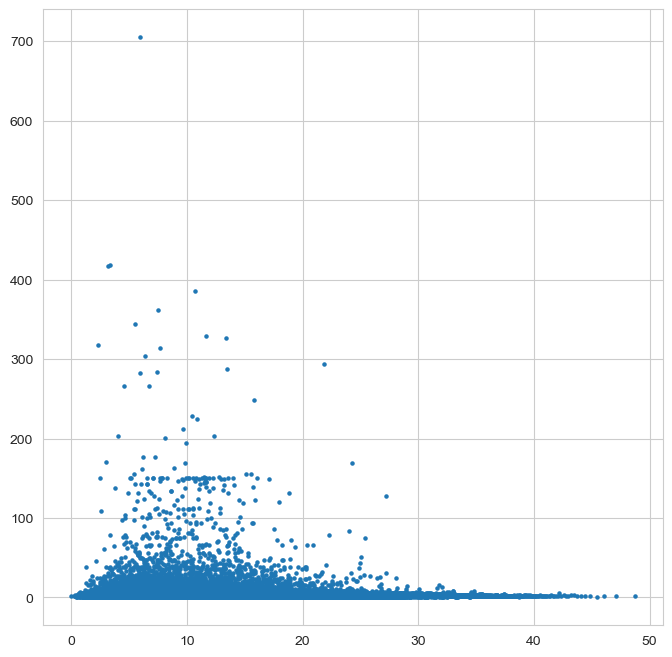

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(chi_square_quantiles, mahalanobis_dist, s=5, label='Chi-Squared Quantiles')
plt.show()